In [21]:
from simtk.openmm import unit

from openmmtools.constants import kB
from openmmtools import multistate, cache, utils
from openmmtools.multistate import MultiStateSamplerAnalyzer, MultiStateReporter

from perses.analysis import utils
from perses.analysis.utils import open_netcdf
from perses.dispersed.utils import configure_platform

import numpy as np
import os
import copy
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

platform = configure_platform('CUDA')
cache.global_context_cache.platform = platform
context_cache = cache.ContextCache(capacity=None, time_to_live=None)

conducting subsequent work with the following platform: CUDA


In [2]:
def retrieve_states(nc, thermodynamic_states, iteration, desired_state_index):
    """
    Retrieve the thermodynamic and sampler states for a given iteration and state.
    """
    
    thermodynamic_state = thermodynamic_states[0][desired_state_index]
    print(f"lambda_alchemical_sterics_new: {thermodynamic_state.lambda_alchemical_sterics_new}")
    replica_id = np.where(nc.variables['states'][iteration] == desired_state_index)[0][0]
    sampler_state = reporter.read_sampler_states(iteration)[replica_id]
    
    return thermodynamic_state, sampler_state

def retrieve_forces(thermodynamic_state, sampler_state, lambda_val):
    """
    Retrieve the forces for at a given lambda (for a particular configuration).
    """
    
    temperature = 300 * unit.kelvin
    T_max = temperature
    beta_0 = 1 / (kB * temperature)
    beta_m = 1 / (kB * T_max)
    thermodynamic_state_copy = copy.deepcopy(thermodynamic_state)
    thermodynamic_state_copy.set_alchemical_parameters(lambda_val, beta_0, beta_m)
    print(f"lambda_alchemical_sterics_new: {thermodynamic_state_copy.lambda_alchemical_sterics_new}")
    
    context, context_integrator = context_cache.get_context(thermodynamic_state_copy)
    print(f"platform precision: {context.getPlatform().getPropertyValue(context, 'CudaPrecision')}")
    print(f"platform deterministic forces: {context.getPlatform().getPropertyValue(context, 'DeterministicForces')}")
    sampler_state.apply_to_context(context)
    
    return context.getState(getForces=True).getForces(asNumpy=True)

def compute_norms(forces_plus_epsilon, forces_minus_epsilon, epsilon=1e-3):
    vectors = (forces_plus_epsilon - forces_minus_epsilon) / (2 * epsilon) 
    return np.linalg.norm(vectors, axis=1) 

# Analyze A42T

In [3]:
# Load nc files
out_dir = "/data/chodera/zhangi/perses_benchmark/repex/33/22/"
i = os.path.basename(os.path.dirname(out_dir))
phase = 'complex'

reporter = MultiStateReporter(os.path.join(out_dir, f"{i}_{phase}.nc"), 'r')
thermodynamic_states = reporter.read_thermodynamic_states()

nc = open_netcdf(os.path.join(out_dir, f"{i}_{phase}.nc"))


DEBUG:openmmtools.multistate.multistatereporter:Initial checkpoint file automatically chosen as /data/chodera/zhangi/perses_benchmark/repex/33/22/22_complex_checkpoint.nc
DEBUG:openmmtools.multistate.multistatereporter:checkpoint_interval != on-file checkpoint interval! Using on file analysis interval of 10.
DEBUG:openmmtools.utils:Reading thermodynamic states from storage took   13.314s


## Try out different epsilons

In [8]:
thermodynamic_state, sampler_state = retrieve_states(nc, thermodynamic_states, 10, 7)
norms_all = []
for epsilon in [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]:
    forces_A = retrieve_forces(thermodynamic_state, sampler_state, 0.2 + epsilon)
    forces_B = retrieve_forces(thermodynamic_state, sampler_state, 0.2 - epsilon)
    norms = compute_norms(forces_A, forces_B, epsilon=epsilon)
    print("epsilon: ", epsilon)
    print(norms[-10:])
    norms_all.append(norms)

lambda_alchemical_sterics_new: 0.19999999999999998
lambda_alchemical_sterics_new: 0.21000000000000002
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 0.19
platform precision: mixed
platform deterministic forces: true
epsilon:  0.01
[5.57880638e-02 1.35263368e+00 9.91979000e-02 3.31021894e+01
 2.88761369e+02 4.94725433e+01 5.74291828e+01 2.24469941e+01
 2.71910106e+02 6.30584986e+01]
lambda_alchemical_sterics_new: 0.201
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 0.199
platform precision: mixed
platform deterministic forces: true
epsilon:  0.001
[5.84023330e-02 1.38352615e+00 1.23171755e-01 3.31163512e+01
 2.88621961e+02 4.93550523e+01 5.71854383e+01 2.24453079e+01
 2.71775955e+02 6.30725636e+01]
lambda_alchemical_sterics_new: 0.2001
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 0.19990000000000002
platform precision: mixed
platform deterministic f

# Average acrosss all states for one iteration

In [10]:
with open(os.path.join(out_dir, "22_complex.pickle"), 'rb') as f:
    htf = pickle.load(f)

INFO:rdkit:Enabling RDKit 2021.09.4 jupyter extensions


In [11]:
topology = htf.hybrid_topology

In [30]:
epsilon = 1e-3
n_states = 36
lambda_schedule = np.linspace(0.,1.,n_states)

norms_all = []
for state_index, lambda_val in enumerate(lambda_schedule):
    thermodynamic_state, sampler_state = retrieve_states(nc, thermodynamic_states, 5000, state_index)
    forces_A = retrieve_forces(thermodynamic_state, sampler_state, lambda_val + epsilon)
    forces_B = retrieve_forces(thermodynamic_state, sampler_state, lambda_val - epsilon)
    norms = compute_norms(forces_A, forces_B, epsilon=epsilon)
    norms_all.append(norms)

lambda_alchemical_sterics_new: 0.0
lambda_alchemical_sterics_new: 0.001
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: -0.001
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 0.02857142857142857
lambda_alchemical_sterics_new: 0.02957142857142857
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 0.02757142857142857
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 0.05714285714285714
lambda_alchemical_sterics_new: 0.05814285714285714
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 0.05614285714285714
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 0.08571428571428572
lambda_alchemical_sterics_new: 0.08671428571428572
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 0.084714285714285

lambda_alchemical_sterics_new: 0.9714285714285714
lambda_alchemical_sterics_new: 0.9724285714285714
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 0.9704285714285714
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 1.0
lambda_alchemical_sterics_new: 1.001
platform precision: mixed
platform deterministic forces: true
lambda_alchemical_sterics_new: 0.999
platform precision: mixed
platform deterministic forces: true


In [39]:
norms_mean = np.mean(np.array(norms_all), axis=0)

In [40]:
indices = []
for i, norm in enumerate(norms_mean):
    if norm > 20:
        print(i, norm)
        indices.append(i)

606 69.44225955443866
607 163.4269925320448
612 21.333397614003545
613 31.700844853094637
615 29.219457636832153
628 35.761896160137546
630 44.22607203415734
631 126.34643060404937
633 30.8905805846238
634 44.10423795761426
637 74.29524107624196
642 20.837852640370663
650 24.527850959791074
652 90.00110300130528
653 76.44007831653312
669 456.62469530704027
670 118.94617678374081
671 302.43412328612897
672 506.7541355494242
673 303.3132366076552
674 90.49864126612715
675 77.89668917111808
676 197.46182064178683
677 157.95172788901837
678 129.66247806262106
679 65.13087157897041
683 23.029816595239325
1446 33.72341743110121
2064 113.1505285198219
2065 102.67975148988522
2066 213.79900907432622
2073 86.60902741290403
2074 157.2947937822294
2075 129.38603912539548
2076 24.481143952163123
2077 60.09414899588617
2078 74.66399856966379
2079 74.10429622976908
2124 23.32771864858167
2192 32.472114839420165
2888 43.0687393357872
2889 105.36720447963745
2890 31.32507202020012
2900 41.055955662468

In [41]:
for atom in topology.atoms:
    if atom.index in indices:
        print(atom.index, atom)

606 TRP38-C
607 TRP38-O
612 TRP38-NE1
613 TRP38-CE2
615 TRP38-CZ2
628 ASP39-N
630 ASP39-C
631 ASP39-O
633 ASP39-CG
634 ASP39-OD1
637 ASP39-HA
642 ALA40-C
650 LEU41-N
652 LEU41-C
653 LEU41-O
669 ALA42-N
670 ALA42-CA
671 ALA42-C
672 ALA42-O
673 ALA42-CB
674 ALA42-H
675 ALA42-HA
676 ALA42-HB1
677 ALA42-HB2
678 ALA42-HB3
23418 ALA42-HB
23419 ALA42-CG2
23420 ALA42-HG21
23421 ALA42-HG22
23422 ALA42-HG23
23423 ALA42-OG1
23424 ALA42-HG1
679 GLY43-N
683 GLY43-H
1446 HOH98-O
2064 LYS27-CD
2065 LYS27-CE
2066 LYS27-NZ
2073 LYS27-HD3
2074 LYS27-HD2
2075 LYS27-HE3
2076 LYS27-HE2
2077 LYS27-HZ1
2078 LYS27-HZ2
2079 LYS27-HZ3
2124 GLN31-NE2
2192 TRP35-HH2
2888 ARG83-CZ
2889 ARG83-NH1
2890 ARG83-NH2
2900 ARG83-HH12
2901 ARG83-HH11
6791 HOH1420-O
8135 HOH1871-O
8137 HOH1871-H2
9119 HOH2200-O
9121 HOH2200-H2
17660 HOH5053-O
19478 HOH5661-O
20084 HOH5863-O
20085 HOH5863-H1
23042 HOH6850-O


In [31]:
max(norms)

808.2290402839833

/home/zhangi/miniconda3/envs/openmm-dev/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

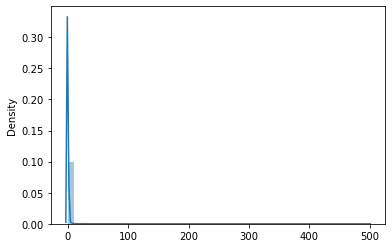

In [22]:
sns.distplot(norms)

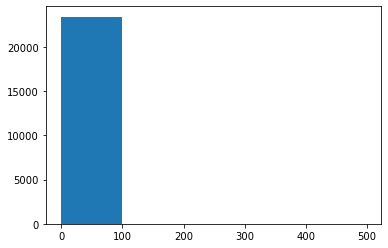

In [19]:
plt.hist(norms, bins=5)
plt.show()

In [28]:
for norm in norms:
    print(norm)

0.4348633666222228
2.2219373497081696
2.1032957618053167
0.13435828985430004
0.15309538221034588
0.11730710472297534
0.6279991060443793
0.5002478238514565
2.747411810787881
2.601971600171602
0.2566886377415032
0.06907430049455394
0.2984102154988437
0.443063319094845
0.41868330833889256
0.3057764956215192
0.16451956609263368
0.03491010450278898
0.03360344936909496
0.022302389297504416
0.023365814560293217
0.04485197298456926
0.05255437018854363
0.12468125542718281
0.1204027123399179
0.21618289954421968
0.20826171652716366
0.2503151896619312
0.7207999379807093
0.29583917915804886
1.1602008994747919
1.2815595916522777
0.22532756534358758
0.0517956418618006
0.24856320675300306
0.43207916066807345
0.1625478730241332
0.290983020323919
0.20727776327959677
0.019214714778462167
0.05262703187642419
0.040559047365687884
0.004069381352331569
0.045236680977160125
0.04209116801274307
0.08151239626935212
0.07992399611886752
0.2009202585792874
0.21114511096730357
0.20856894921029492
0.3800770684460486

0.11648107984152853
0.27692705402956447
0.12952872402728038
0.13492806534988985
0.6212299298711805
0.35577382862459206
0.28054482307587636
0.1291973539266132
0.07191393639591921
0.05671155648670311
0.12892604535004568
0.06680657059956904
0.04871446449054955
1.7222103968820142
0.9315640880239927
0.875448089444031
0.3423093036971344
0.17252809220421003
0.15926646612657344
0.20446919682704767
0.10029915700697768
0.09859004641201224
0.2962322781850108
0.15514997440995432
0.16311320445987526
0.3106036871812107
0.1322215358069731
0.13759127730738946
0.2666662513727513
0.1475387259738157
0.12520971114586005
0.15303650117432518
0.08923545917702867
0.07093626379031381
0.19403464297540307
0.1022712884638896
0.09789920922705718
0.2757306486506431
0.14587208759859394
0.13451710612083242
0.9584546681504669
0.426756469705491
0.5015325650310253
0.23265939947790498
0.10600916898448806
0.12060492844595713
0.34272977578821395
0.16094861126947316
0.18689271136582394
0.2798591738194046
0.1370803684003159


0.6871363773574256
0.4038671084157801
0.3563103447170235
0.8747468496968597
0.3972358023983586
0.4033890173456069
0.13039905269727486
0.07082918025065285
0.06204016100803601
0.29045019871111327
0.1460578466292211
0.12724428827281786
0.29020702761800055
0.14993178451290873
0.15288715705961
0.15179027018696703
0.07580811069290469
0.06439464700172744
0.04622124029561094
0.020522009900098153
0.025061183830638722
0.11063058819864041
0.049770270991347294
0.05911675088315779
0.16986382608944775
0.07469658268703015
0.08162276682496215
0.6118309450439035
0.31590560697004655
0.3054159679555225
0.3885447535964015
0.19406529097184988
0.20873437670952327
0.33370732333611786
0.17182128299752952
0.16813378947708582
0.30298189505983186
0.14973673818332517
0.16310061475100693
0.13538993009579026
0.07618632493344434
0.07597289484498038
0.24355131789754367
0.1231283661774507
0.12594640563994527
0.18009462292075162
0.08884163779735058
0.08592236444247309
0.45321208384496975
0.19896455403675278
0.229830069

0.2717620425349516
0.1282514680432113
0.1333278497939648
0.1678148423691194
0.0744084311425879
0.09799699688990071
0.8834288304885501
0.502120848380454
0.4608734122801525
0.11446897838218631
0.0866618739560967
0.05182026582721697
0.3786634998880904
0.187869301852484
0.17445842718228322
20.50204831163898
8.22311900871203
7.823593722673121
0.2855374800975069
0.14505649692168956
0.15004846331232066
0.5215444019727034
0.2748581835844922
0.23710329874507488
0.30086802277903074
0.15544543964506188
0.14415257339309376
0.19784317900853068
0.09590118767775138
0.09220112243064918
0.5721396170921782
0.2977545480802946
0.26926230545925384
0.3358017139691439
0.13386815754216452
0.15890701140509508
0.0975608599908398
0.050789175609507166
0.04881736849466207
0.22024715529096148
0.12201535209553142
0.12310343402314745
0.4154223958937821
0.19437183415208964
0.20026720700654277
0.4761347365428479
0.24256158342242182
0.21865778508322328
2.079825784052632
1.0116463001284428
0.9786078961290633
0.8865787773

0.24476938939456844
0.11700110898506573
0.11163490113330844
0.32061368897390413
0.17068905435497023
0.15891685944055792
0.1952611773830705
0.08429047865333823
0.0995162690599151
0.3232846919334535
0.1578741510024241
0.14973374862713687
0.4093985107580704
0.199491821985648
0.21176885246902075
1.9845346705218763
1.1803396905337522
0.9701700509578547
0.09675447775348049
0.04220008850097656
0.0453778894202096
0.31916367738457796
0.15674240134370823
0.16998157894496732
0.38496329261386875
0.19345864929962842
0.19903400180739217
0.15813623372275062
0.07840392345603768
0.07329100800224299
0.36026932826708213
0.1779477378762692
0.18710937582010828
0.17449894731876647
0.0886942750293667
0.08865388966203616
0.19170514314759654
0.09969888462603949
0.08485022132696238
0.17946062767214752
0.09535431771713018
0.08685932746861873
0.264114415806067
0.1281544218848204
0.13676002264773643
0.24209995054885153
0.08274052207908936
0.1095117551281746
0.5894082452324331
0.29846216302453715
0.2880369775003247

0.13572615006230457
0.09929668706417306
0.053907911718410584
0.061497205982445076
0.2614968193429378
0.13130977648153253
0.13156062981843106
0.34732636614117945
0.17225805244528938
0.18250486722029613
0.7787509958293906
0.37429135227465915
0.3840201029951986
0.19682086384791928
0.09741616551080673
0.1097435306873022
0.5053808060463756
0.24363068810252628
0.2477007255741875
0.18912590417847502
0.10402593587836517
0.08789112636055603
0.09198879662923809
0.047319931907864675
0.05350412523580918
0.19666295796695582
0.09430893946128813
0.08364823875020837
0.29901758248737614
0.1438563257008228
0.14359133770136598
0.8655496818219106
0.42522352950389253
0.49245621556534774
0.07230397197687526
0.026627203447806124
0.03636274079620804
0.27434675784474005
0.13781253838492974
0.13112675055339643
0.7039130791657398
0.3767921845267356
0.30724025181698383
0.1271216026531344
0.06709354683145845
0.06984286637263692
0.14067261894617364
0.08026893578396055
0.07715926592319025
0.10195521740728487
0.05045

In [25]:
indices = []
for i, norm in enumerate(norms):
    if norm > 20:
        print(i, norm)
        indices.append(i)

606 33.13692358513129
607 89.08696682189822
628 22.681100294678572
630 34.008129710023525
631 50.562130686398056
633 40.41320068279065
634 44.111559927611125
635 23.76545926042418
637 24.7741121482959
652 82.17438177631868
653 66.04867804982872
669 497.4296942166332
670 112.06742957402938
671 187.79895269752214
672 157.0947283012546
673 402.1969342022257
674 71.63784602177493
675 91.49882081516266
676 247.3528980106596
677 141.01777868424253
678 65.49767968333003
679 54.92711491818414
1662 37.42214811231781
1663 21.666742866806523
1664 25.15215215291995
2066 38.95842703954795
2074 31.414237142089597
2077 23.79601609388399
2078 53.336803954477205
2079 56.28011753786497
2123 20.034012602428824
2743 22.961631094110786
2744 32.49827968403412
2745 20.13646541198629
2887 27.80759423361196
2888 65.15722785425845
2889 90.13115951841715
2890 47.344450647887314
2900 52.35267262284792
2901 63.32424794484882
2902 27.07605889589248
3380 27.610479500793993
5339 28.708560520628005
5465 97.23080880598

In [26]:
for atom in topology.atoms:
    if atom.index in indices:
        print(atom.index, atom)

606 TRP38-C
607 TRP38-O
628 ASP39-N
630 ASP39-C
631 ASP39-O
633 ASP39-CG
634 ASP39-OD1
635 ASP39-OD2
637 ASP39-HA
652 LEU41-C
653 LEU41-O
669 ALA42-N
670 ALA42-CA
671 ALA42-C
672 ALA42-O
673 ALA42-CB
674 ALA42-H
675 ALA42-HA
676 ALA42-HB1
677 ALA42-HB2
678 ALA42-HB3
23418 ALA42-HB
23419 ALA42-CG2
23421 ALA42-HG22
23422 ALA42-HG23
23423 ALA42-OG1
23424 ALA42-HG1
679 GLY43-N
1662 HOH170-O
1663 HOH170-H1
1664 HOH170-H2
2066 LYS27-NZ
2074 LYS27-HD2
2077 LYS27-HZ1
2078 LYS27-HZ2
2079 LYS27-HZ3
2123 GLN31-OE1
2743 GLU73-CD
2744 GLU73-OE1
2745 GLU73-OE2
2887 ARG83-NE
2888 ARG83-CZ
2889 ARG83-NH1
2890 ARG83-NH2
2900 ARG83-HH12
2901 ARG83-HH11
2902 ARG83-HH22
3380 HOH113-O
5339 HOH935-O
5465 HOH977-O
5466 HOH977-H1
5467 HOH977-H2
6221 HOH1230-O
8096 HOH1858-O
8135 HOH1871-O
8137 HOH1871-H2
8531 HOH2003-O
8532 HOH2003-H1
8533 HOH2003-H2
9488 HOH2323-O
9489 HOH2323-H1
9490 HOH2323-H2
11648 HOH3044-O
11816 HOH3100-O
12581 HOH3355-O
12582 HOH3355-H1
12583 HOH3355-H2
12713 HOH3399-O
12714 HOH3399-H1

In [14]:
std = np.std(norms) 
# DAR suggests taking the stddev of the norms and dividing each one by it to scale the standard deviation to 1 (common ML trick)
# Double check that the platform is mixed and that deterministic forces = True
# Try out different epsilons and look at the last couple of norms (without scaling the stddev) and make sure they are close to each other
# Collect unscaled norms for all the data (all states and iterations), then compute the stddev for all the data

In [15]:
print(std)

2.4181608856723566e-10


In [16]:
for i, norm in enumerate(norms):
#     if norm / std > 10:
    print(i, norm/std)

0 0.9164697727073225
1 7.583584508186169
2 7.580126142152906
3 0.24322550942123183
4 0.3241067498973122
5 0.33814182417635597
6 0.6899852801827197
7 1.7589659037713339
8 6.786963369367651
9 7.26849028449303
10 0.692765820047408
11 0.37227917119446297
12 0.7232363815194248
13 0.8634076093744903
14 0.7332919420454209
15 0.09290327675913276
16 0.1181487075189514
17 0.23297938520013636
18 0.2327452772817947
19 0.2613563957079852
20 0.36871627960851777
21 0.3952874959212079
22 0.3634530967291683
23 0.2671432892925565
24 0.35447071747569453
25 0.22268709017161578
26 0.2948782597512988
27 0.26502126053273106
28 0.7039408475549778
29 1.7393172300610886
30 6.615167498309647
31 7.192390244555781
32 0.6842001820277068
33 0.25717794077417117
34 0.4662794095741006
35 0.7812955667289591
36 0.954545592034112
37 0.03717816912491434
38 0.11173513573724125
39 0.21225053200993355
40 0.24053513760807127
41 0.22818279788810314
42 0.22957841537220958
43 0.3812463773629709
44 0.3621141528524301
45 0.28161005

1550 0.045482121615853285
1551 0.10582326159595093
1552 0.00966029791414541
1553 0.029512697618263573
1554 0.2617209872170953
1555 0.066928507214206
1556 0.0358349095097117
1557 0.07658109396535455
1558 0.07296030201319748
1559 0.013697255529347134
1560 0.12644785074762596
1561 0.02096158510652559
1562 0.05809580335738424
1563 0.21396932932577276
1564 0.038732278518023376
1565 0.10196005698503839
1566 0.0685723698365756
1567 0.032143849741839044
1568 0.017964864470420103
1569 0.10248190531115398
1570 0.06263693265962467
1571 0.04378328657741958
1572 0.061730235930971364
1573 0.039106934460299024
1574 0.050850557846980254
1575 0.11871188656059369
1576 0.03509570106192974
1577 0.11691825115307243
1578 0.022655406790548515
1579 0.04753056372571166
1580 0.04050507719862487
1581 0.1422504152793264
1582 0.04851234833864596
1583 0.08291447347159125
1584 0.06371404065719607
1585 0.03527442053198364
1586 0.03614552504889907
1587 0.05176002887498351
1588 0.07613910910838993
1589 0.05245263411172

3299 0.020362283415889148
3300 0.04513334496342421
3301 0.054646728237234724
3302 0.03235098716513412
3303 0.3014330595990012
3304 0.39774396260452216
3305 0.4188848690310104
3306 0.7138382419843744
3307 1.9801235633396068
3308 6.589669546947779
3309 7.0631095514501725
3310 0.9362423217576764
3311 0.35306431539764926
3312 0.6790250883697226
3313 0.7033118734031842
3314 1.0078703775949662
3315 0.030073496151297213
3316 0.11208869995335277
3317 0.040253910960637414
3318 0.18426095026161166
3319 0.14500446286923774
3320 0.1905261189153638
3321 0.3034446731956579
3322 0.3010887023123611
3323 0.30292743726185534
3324 0.1196013478928845
3325 0.3475265374148708
3326 0.35784589422554386
3327 0.3444111683867736
3328 0.6477410015995235
3329 1.6306213182863893
3330 7.811851776151286
3331 7.377013854505243
3332 0.4130483912993219
3333 0.3845414859531289
3334 0.9243593609021495
3335 0.7310055957178839
3336 0.01195400878590534
3337 0.1019461459320228
3338 0.16043550939206147
3339 0.15197332618616954

5049 0.06273772868008737
5050 0.12120770955157355
5051 0.0402190274251802
5052 0.023662800652928914
5053 0.0733854202621362
5054 0.08366063401775749
5055 0.04500945565777076
5056 0.09467174100896547
5057 0.14574145752379483
5058 0.05804767701955882
5059 0.05915573002179273
5060 0.11361977916552427
5061 0.07586050975564251
5062 0.05521320152350081
5063 0.09813298858851212
5064 0.05505506901598696
5065 0.06529651316632691
5066 0.1402685014976654
5067 0.08396219835123879
5068 0.05702338108889442
5069 0.10331326182289509
5070 0.047533120163187
5071 0.06744395467106333
5072 0.13524417079803575
5073 0.08130352207496704
5074 0.09898859711075023
5075 0.07778389657926892
5076 0.06010253028816299
5077 0.04338180119703635
5078 0.05194749790184368
5079 0.031194062794102646
5080 0.013246267052811605
5081 0.07681715031926081
5082 0.046809269019647146
5083 0.05044811092877463
5084 0.05742259634715376
5085 0.024391056622490113
5086 0.029512697618263573
5087 0.09597705712534677
5088 0.07708716981069005

6799 0.04270427177379808
6800 0.1540103176088182
6801 0.07295572186508668
6802 0.043247144479438504
6803 0.11402971355489999
6804 0.059288315892972725
6805 0.02049258649012344
6806 0.11327703395274258
6807 0.05280128316838057
6808 0.05796178748487247
6809 0.17464400872645316
6810 0.07300192654278312
6811 0.08712139196311143
6812 0.08468424379645745
6813 0.04509576341806403
6814 0.015116337462672075
6815 0.0716698190194234
6816 0.03320018361561585
6817 0.04285197888849836
6818 0.050505284128770325
6819 0.028937950854106668
6820 0.016761150462491315
6821 0.08053467717330175
6822 0.019016315460320208
6823 0.06722559835080696
6824 0.09341063518876715
6825 0.08130352207496704
6826 0.056466624267435844
6827 0.1188550387350811
6828 0.02795650827162797
6829 0.07156122832217571
6830 0.11601394780440938
6831 0.024252416726163684
6832 0.05637889862866223
6833 0.060437711303131164
6834 0.025715913680332356
6835 0.040968121925804075
6836 0.07667623761487424
6837 0.05978274879605973
6838 0.026492534

8549 0.05830458647605277
8550 0.05636323701390845
8551 0.05654404065208898
8552 0.03210020721919173
8553 0.07367791541218321
8554 0.03870403312216191
8555 0.13366897272116865
8556 0.0813991170780924
8557 0.04386715936247247
8558 0.0459923825605615
8559 0.06717542070967629
8560 0.0036342464625846427
8561 0.033391779994820986
8562 0.03559966624398573
8563 0.05159072431095046
8564 0.0662276658363556
8565 0.032655641310384044
8566 0.05698074677931617
8567 0.05105088911985919
8568 0.06932611758405471
8569 0.04288599290011539
8570 0.08053467717330175
8571 0.06930157457216733
8572 0.061224241856474036
8573 0.10640954453991326
8574 0.07616743148013431
8575 0.061224241856474036
8576 0.14306810978207518
8577 0.09316053933116704
8578 0.09694451096386099
8579 0.1322202732236421
8580 0.04322747199498454
8581 0.035661554887628795
8582 0.02554091128298202
8583 0.031116058013856564
8584 0.05126940141467932
8585 0.06750698389362189
8586 0.10473833964986597
8587 0.05126940141467932
8588 0.14592060402639

10298 0.08897618604354339
10299 0.04146854711613075
10300 0.04466255680110747
10301 0.17362801130580344
10302 0.08752215693430222
10303 0.05572144358262082
10304 0.09724486646291897
10305 0.06969104616283799
10306 0.07558450072449803
10307 0.042707117112894
10308 0.03255501883832159
10309 0.0182284135823444
10310 0.09996701892898337
10311 0.024580873155482446
10312 0.0341133722635143
10313 0.07887600217642972
10314 0.027791944606292356
10315 0.02929885338828412
10316 0.10908012130186864
10317 0.06876250451151027
10318 0.12229357858371143
10319 0.04192317021305118
10320 0.048140215365666095
10321 0.02123801355239869
10322 0.055564210790045074
10323 0.02728784805381408
10324 0.03460670550590171
10325 0.11382493090495387
10326 0.07123115793933313
10327 0.05161898030082475
10328 0.08993247931163129
10329 0.050273784281475255
10330 0.035122523711282765
10331 0.1331580174082958
10332 0.1124501832348472
10333 0.074202156246382
10334 0.05364148087248307
10335 0.03943800108821485
10336 0.023331

12048 0.08295005603207507
12049 0.07701147044400859
12050 0.10717417385650499
12051 0.07230617638569123
12052 0.018046269332794344
12053 0.14903181767001983
12054 0.028507428388724998
12055 0.06058580687263582
12056 0.10398851908826827
12057 0.07352437659463304
12058 0.04981731431481864
12059 0.09603780851266773
12060 0.04942550867007423
12061 0.07588613397855051
12062 0.1422504152793264
12063 0.06733396271916733
12064 0.05580860372283701
12065 0.18906604046578734
12066 0.08919442572885984
12067 0.09209405965825096
12068 0.2515699361707335
12069 0.06371404065719607
12070 0.14756348809131783
12071 0.046830031615043684
12072 0.047037153508571454
12073 0.06273772868008737
12074 0.10598848146485695
12075 0.07332081530406577
12076 0.0358349095097117
12077 0.1640599810744291
12078 0.04438486511156062
12079 0.04573788064205401
12080 0.09131782641858417
12081 0.02708508650502712
12082 0.06623407981812077
12083 0.12041513881517474
12084 0.07958760597133897
12085 0.06367254665041315
12086 0.1608

13798 0.01673938743604924
13799 0.04338180119703635
13800 0.017190626127877567
13801 0.02058724097298555
13802 0.11720785489999859
13803 0.06341846958017515
13804 0.04114200645951406
13805 0.05770598402349679
13806 0.03218927717567856
13807 0.028060629705665564
13808 0.4533312023333174
13809 0.05521320152350081
13810 0.09079309680873536
13811 0.05786107187883545
13812 0.04577240481293564
13813 0.005309503388099672
13814 0.10250561644849057
13815 0.059175485307709226
13816 0.06103540346648454
13817 0.07768385294098164
13818 0.024942781960591617
13819 0.05876129818368175
13820 0.12949758747055343
13821 0.02373293703286874
13822 0.01924120074906685
13823 0.08897618604354339
13824 0.0660807216441305
13825 0.06285383092364738
13826 0.14756348809131786
13827 0.06499983514421968
13828 0.018721695677254784
13829 0.09668344810929407
13830 0.04338180119703634
13831 0.034211187310587636
13832 0.24908462024195652
13833 0.0493369235987639
13834 0.04233848968886026
13835 0.07942599163413805
13836 0.

15548 0.1461488012652344
15549 0.0359432541545475
15550 0.07293364984718921
15551 0.14930552188163143
15552 0.03787896309657774
15553 0.07401851972878404
15554 0.07968525951233045
15555 0.05364148087248307
15556 0.05052993889427528
15557 0.11725760708684481
15558 0.024648750680134286
15559 0.05660418019420575
15560 0.2525264206438516
15561 0.008380575231245658
15562 0.044792958704308716
15563 0.08550097013826222
15564 0.09800164726536577
15565 0.09339502381819122
15566 0.10404459270738144
15567 0.04741794403035974
15568 0.053677712879905304
15569 0.18077333924909736
15570 0.08805919263585611
15571 0.09363289551029567
15572 0.21263858769689845
15573 0.11124317345844682
15574 0.06898832615227123
15575 0.0910496958040795
15576 0.0512314662253086
15577 0.03352230092498263
15578 0.09047166040723816
15579 0.02665828195015452
15580 0.06087393122535781
15581 0.12872177289353168
15582 0.06910096022914944
15583 0.039018474054348065
15584 0.28837142175679076
15585 0.02859255078895577
15586 0.1079

16472 0.17178181038391765
16473 0.0981602260863424
16474 0.03747907181523262
16475 0.21848083093627818
16476 0.11133816399050807
16477 0.07130436676676291
16478 0.04571662203963112
16479 0.03700925986439202
16480 0.03485162509058606
16481 0.1331580174082958
16482 0.014887518933702491
16483 0.052911630797975465
16484 0.06468313111819461
16485 0.06578584859043171
16486 0.0408068982205039
16487 0.15070529176310138
16488 0.05752407965992948
16489 0.05585213278625436
16490 0.04732560130585783
16491 0.018557088237108135
16492 0.054584601336716984
16493 0.08967268345065829
16494 0.015218482806339449
16495 0.04886175756453349
16496 0.07401851972878404
16497 0.051155511452293835
16498 0.06529639685815405
16499 0.1602949779651823
16500 0.07897453563418073
16501 0.06762208539901787
16502 0.09497928402045054
16503 0.03161196268690649
16504 0.029512697618263573
16505 0.12510303371203668
16506 0.09232725812535897
16507 0.07105854777285964
16508 0.12864286646928444
16509 0.0738097362724441
16510 0.04

18297 0.11133816399050807
18298 0.1080234134971667
18299 0.11864219807892142
18300 0.04046000637852549
18301 0.0481402153656661
18302 0.1301313978655117
18303 0.05657197053309673
18304 0.0775084658536341
18305 0.1035951539207064
18306 0.049519456673311577
18307 0.027109143786674308
18308 0.22309502404735335
18309 0.095245018036415
18310 0.07441147163044935
18311 0.0449689418726779
18312 0.03842122776863233
18313 0.018005402012306805
18314 0.1050117781133303
18315 0.04113905287133699
18316 0.05529237288794927
18317 0.15979159805040447
18318 0.08378255027648797
18319 0.05627693588073676
18320 0.05577375601183833
18321 0.01626070441499341
18322 0.021681094901727913
18323 0.15835474725675025
18324 0.09648718742668817
18325 0.0209615978438476
18326 0.09034767478612966
18327 0.033069769248734664
18328 0.04604502743896479
18329 0.1196213800057211
18330 0.041374673657608295
18331 0.046034470284764595
18332 0.02563470070733966
18333 0.03181121581845418
18334 0.025828315455723776
18335 0.0596560

20797 0.1641332897439811
20798 0.11375658810029061
20799 0.036573297631704894
20800 0.05742259634715376
20801 0.09538779895526006
20802 0.04834172405464703
20803 0.0417489010498512
20804 0.27750596475735023
20805 0.14540339601854313
20806 0.10872753636588489
20807 0.17009852640378065
20808 0.06774416646816575
20809 0.0701342507488327
20810 0.07148183224571558
20811 0.035494200979393375
20812 0.07537199435943576
20813 0.037205735815224676
20814 0.03571262889320681
20815 0.05650104464507147
20816 0.10728296174496614
20817 0.04192317021305117
20818 0.03443775394096504
20819 0.05915700163232228
20820 0.028711298173576885
20821 0.02795650827162797
20822 0.17339270493216236
20823 0.11923474869407508
20824 0.04773464608863109
20825 0.07601572405560235
20826 0.062277130751844566
20827 0.04418112370619058
20828 0.048782113244980226
20829 0.025020606742407338
20830 0.040711499146179754
20831 0.08471939119408695
20832 0.026529201990446328
20833 0.050505284128770325
20834 0.1068471456098937
20835 

22547 0.04021902742518021
22548 0.013943439002959584
22549 0.00881860513299591
22550 0.13298269407036764
22551 0.026766318857470908
22552 0.043247144479438504
22553 0.1720193203250511
22554 0.07203679091459335
22555 0.06893892934043833
22556 0.06718943805646309
22557 0.058153064897398556
22558 0.037205735815224676
22559 0.0835880712486781
22560 0.08042143619772771
22561 0.04352720921480133
22562 0.03527442053198364
22563 0.01893948154828887
22564 0.014887518933702491
22565 0.05439728537812574
22566 0.04913949614177318
22567 0.052911630797975465
22568 0.03338063374334982
22569 0.023846949738815015
22570 0.017737255375849154
22571 0.07657474685217258
22572 0.06058580687263582
22573 0.06578584859043171
22574 0.1019683989819421
22575 0.03794626934122333
22576 0.04359694428661256
22577 0.1765710979687426
22578 0.0410799365124866
22579 0.05963712410801963
22580 0.07253614733644498
22581 0.04003734138507705
22582 0.05663865106361072
22583 0.10344490706292973
22584 0.060714030945957335
22585 0

In [17]:
std = np.std(norms_all[0]) 
# DAR suggests taking the stddev of the norms and dividing each one by it to scale the standard deviation to 1 (common ML trick)
# Double check that the platform is mixed and that deterministic forces = True
# Try out different epsilons and look at the last couple of norms (without scaling the stddev) and make sure they are close to each other
# Collect unscaled norms for all the data (all states and iterations), then compute the stddev for all the data

In [18]:
print(std)

0.0006820887753833245


In [19]:
for i, norm in enumerate(norms_all[0]):
#     if norm / std > 10:
    print(i, norm/std)

0 0.08020306068101464
1 0.12280936020643547
2 0.11645723570348107
3 0.0268910294374243
4 0.026400967535217566
5 0.02154951654570086
6 0.06848398727856544
7 0.04362175579095518
8 0.15167314072385182
9 0.13866209648292363
10 0.0014949819754349319
11 0.002986059993218877
12 0.007386016004486706
13 0.00235938534454857
14 0.05562930908006139
15 0.053419432104119674
16 0.024316032424283707
17 0.005243970032578276
18 0.005216934928774649
19 0.0019001186957486268
20 0.0014924559672171232
21 0.008454297781791633
22 0.010258086345451563
23 0.021157748476189238
24 0.017904147270322853
25 0.04988608832982317
26 0.043820187610101806
27 0.04848068956152472
28 0.06830079370693075
29 0.05129379689201616
30 0.15589742235828113
31 0.10953800049312593
32 0.001876095860660034
33 0.0030365332802124545
34 0.007101404688631807
35 0.001807838813532116
36 0.04446577920273453
37 0.047961176461017795
38 0.03555461261517779
39 0.007086304075616069
40 0.007394597233191136
41 0.001640716583126336
42 0.0015782305941

1862 0.07655534644592932
1863 0.03960893436355401
1864 0.010381299991726866
1865 0.0019916765631463242
1866 0.0021448787879783096
1867 0.0035710442147448263
1868 0.003510062021768869
1869 0.03260826676012355
1870 0.03387900103345396
1871 0.04584383909650076
1872 0.0037362417252103167
1873 0.06101593698047921
1874 0.0525786214444526
1875 0.03476220391256616
1876 0.06184472924599177
1877 0.02056634255411881
1878 0.03175377502753865
1879 0.009150835341385503
1880 0.00044598529001303554
1881 0.04082132586015425
1882 0.00527365127427247
1883 0.005494444429593599
1884 0.004980214602307799
1885 0.04831520135379977
1886 0.0001948780086136582
1887 0.07780718094735396
1888 0.0731166668763886
1889 0.0018372320276694922
1890 0.00020014098680164785
1891 0.018331435260077137
1892 0.021931068482588148
1893 0.020627853851482726
1894 0.024190698564434888
1895 0.02946768275969339
1896 0.04657047877234531
1897 0.034289271396533615
1898 0.009357453469915808
1899 0.0034839687383012314
1900 0.00398660741813

4362 0.030874364192889563
4363 0.030826079477371662
4364 0.04881525145088459
4365 0.0237048060661326
4366 0.024052934946588812
4367 0.033953222226479715
4368 0.017916308815617194
4369 0.015996922125174173
4370 0.04970846131649923
4371 0.022083684023630867
4372 0.026034284137512798
4373 0.024169978466487697
4374 0.010930412747570999
4375 0.011799209518162906
4376 0.02305748208563339
4377 0.011613159413076661
4378 0.011540472688274999
4379 0.05607514846547562
4380 0.0278481818405443
4381 0.029837362631397683
4382 0.19250756721162848
4383 0.11170364991464603
4384 0.09442416844109809
4385 0.04851301130690503
4386 0.02333028736611044
4387 0.026288719572647706
4388 0.1043541317770807
4389 0.054080178186812614
4390 0.04675230297183933
4391 0.0700259777642101
4392 0.03564163559743384
4393 0.03715616816701126
4394 0.011955150368976425
4395 0.005874664258298695
4396 0.006496334968470107
4397 0.027394453449327186
4398 0.013467889589258122
4399 0.014840960421255751
4400 0.0083374145593754
4401 0.0

7112 0.019672230775817746
7113 0.010885748754842453
7114 0.009432670595623338
7115 0.16944705994230377
7116 0.09161457566393828
7117 0.08105435067092723
7118 0.08999884234270836
7119 0.04183576370182168
7120 0.045142023945539844
7121 0.07250038543317057
7122 0.03448460183844168
7123 0.04155807879612325
7124 0.060418680129674183
7125 0.029340957759673707
7126 0.03249966923663868
7127 0.008242704007788699
7128 0.004065116227083799
7129 0.004584109978200318
7130 0.02587631551485426
7131 0.013944743709300102
7132 0.01226261407993871
7133 0.020206727105235158
7134 0.010121199277377544
7135 0.010591737242372737
7136 0.13738887004462436
7137 0.07016902457031869
7138 0.060990133109040404
7139 0.008139091024854665
7140 0.004233605999930569
7141 0.0038646184085345345
7142 0.047746253237197805
7143 0.024415515671571814
7144 0.024444898519808377
7145 0.06399754923817783
7146 0.029482029166732558
7147 0.03135526482290013
7148 0.0299367535312809
7149 0.01454221218281938
7150 0.01484963747638812
7151

9861 0.008005009227787097
9862 0.007898695995928172
9863 0.02550154690841347
9864 0.012206852546971937
9865 0.013931185522807475
9866 0.05814569740129618
9867 0.029715811472721974
9868 0.030575598121497342
9869 0.009289191821242125
9870 0.0048770797972800504
9871 0.00439466603160957
9872 0.0690483315940205
9873 0.03399848057732121
9874 0.03535579609869763
9875 0.04353932917063081
9876 0.02449439181660006
9877 0.02176586243075624
9878 0.03938738926755843
9879 0.018760010284516324
9880 0.019008883362500145
9881 0.0360562960240914
9882 0.018131035131810986
9883 0.01608037380503634
9884 0.019146422670518956
9885 0.00920377900450814
9886 0.00957232237565956
9887 0.0163828237459231
9888 0.0076902386745352
9889 0.007998556533126384
9890 0.09106162480805671
9891 0.04206438689719377
9892 0.04249837879936347
9893 0.013224549488924207
9894 0.007357456780315489
9895 0.005719289158703271
9896 0.028658643561067888
9897 0.014999075398017363
9898 0.013074682300565398
9899 0.02827902092476744
9900 0.01

11094 0.008327187600500767
11095 0.01022880607723712
11096 0.023994806280737746
11097 0.011460105359357584
11098 0.012744463999106354
11099 0.5812147921568398
11100 0.30980875987277834
11101 0.22601165110173735
11102 0.03641359534314093
11103 0.016266607113126785
11104 0.018055288969833366
11105 0.007360511689722209
11106 0.0035502343115559874
11107 0.00397856377356059
11108 0.024678055341435294
11109 0.012359553029495925
11110 0.012254286059861855
11111 0.04159573748794019
11112 0.023050687087531767
11113 0.020568643538164615
11114 0.0666620018870611
11115 0.03185383187475575
11116 0.032945728066786736
11117 0.04263184309007114
11118 0.0212416473167577
11119 0.01940668997178023
11120 0.022187535128603646
11121 0.010988159565995682
11122 0.011449480920908925
11123 0.062277328551515125
11124 0.029177106027311835
11125 0.03451510841991193
11126 0.014775236151537747
11127 0.007887501716997512
11128 0.008350770839759939
11129 0.06896107658120591
11130 0.03286587592736538
11131 0.0362420184

13861 0.0020885177311596214
13862 0.04688373784791414
13863 0.023609092254946257
13864 0.023837173135134518
13865 0.028222896372832814
13866 0.013408433487550567
13867 0.015546102034413742
13868 0.02484387161573793
13869 0.012457888629004415
13870 0.0125185326902913
13871 0.007740372256420458
13872 0.003619930835175442
13873 0.0036901573009842474
13874 0.03531522416554299
13875 0.01681224773458256
13876 0.019783384064755733
13877 0.08695981856092141
13878 0.04285273447686606
13879 0.038928206263959014
13880 0.15095408759573653
13881 0.08223769740794282
13882 0.06368360345353163
13883 0.0285080109380406
13884 0.014985174252942388
13885 0.012510530926472236
13886 0.038922030881391394
13887 0.021937964739961423
13888 0.01721763051856187
13889 0.019050399497306962
13890 0.00894678593484442
13891 0.009985578337050108
13892 0.012763139897833405
13893 0.006905535394167739
13894 0.005699711709701593
13895 0.0646576058402961
13896 0.03762241259487042
13897 0.030996274764474956
13898 0.015560479

16611 0.03956824460656854
16612 0.03862343193192769
16613 0.078961654294868
16614 0.03566138157561983
16615 0.03885174879308658
16616 0.02460871708861443
16617 0.012262853078936717
16618 0.01368234729998185
16619 0.02098220796844222
16620 0.009269198991850648
16621 0.010729851120016029
16622 0.022510652087940907
16623 0.010818168658920557
16624 0.01173181003130983
16625 0.03625212073202028
16626 0.018374642682019028
16627 0.019055116054026308
16628 0.00683244815951622
16629 0.003351557839572842
16630 0.0034362009382591045
16631 0.044709118680536376
16632 0.02150075252877329
16633 0.022876894940127256
16634 0.12819941903940393
16635 0.06664324679300995
16636 0.058772257961107244
16637 0.03436646148759749
16638 0.016967458928164463
16639 0.01722750096796056
16640 0.07700718500288599
16641 0.04131911541374152
16642 0.03977070753041
16643 0.008091527895507643
16644 0.0040239920207471415
16645 0.0035933192205161884
16646 0.01597539532697868
16647 0.008917001246278169
16648 0.007627077069586

19360 0.028112672850184272
19361 0.06385543967876768
19362 0.031479133061113294
19363 0.0307891367353065
19364 0.008620663945435807
19365 0.005233018721994638
19366 0.0045405283251901156
19367 0.028310114887085288
19368 0.01331305969235696
19369 0.014808335837192177
19370 0.08738349323400134
19371 0.042830739491559904
19372 0.04244385117785977
19373 0.15221641515506407
19374 0.06750611715558251
19375 0.07622595535039181
19376 0.031151421562559966
19377 0.016690987984209472
19378 0.015948047213813817
19379 0.0056950442344411364
19380 0.002878455992497297
19381 0.0031528365738192803
19382 0.045347642600522535
19383 0.02292793041374326
19384 0.024422727874322644
19385 0.020880407799198822
19386 0.011255328215022621
19387 0.011729651973569781
19388 0.16904642181855234
19389 0.09357769352741509
19390 0.08043632367002843
19391 0.07917520373249756
19392 0.03866348668067819
19393 0.040462869103733506
19394 0.046277981671754315
19395 0.023184859905928838
19396 0.02167029576269391
19397 0.026030

22110 0.0687677338399679
22111 0.05962227021882549
22112 0.02773012750341903
22113 0.014478818761761703
22114 0.013520179732647975
22115 0.009121336188576511
22116 0.004029549123437211
22117 0.004539546305343879
22118 0.028668215559806743
22119 0.01512267881763371
22120 0.01442799222591803
22121 0.016937435214895595
22122 0.007949086052515429
22123 0.008560611270186452
22124 0.028095095343807046
22125 0.014158060135087754
22126 0.015604578853011556
22127 0.01391603364075008
22128 0.006492091502835704
22129 0.007746020528950258
22130 0.1300454618774431
22131 0.057694971621963666
22132 0.06372177593827792
22133 0.029144712445007017
22134 0.013646287902312407
22135 0.015768333560582593
22136 0.0037832509432775704
22137 0.002101546125884841
22138 0.000992064827047
22139 0.03997720382036462
22140 0.020724789339671604
22141 0.02204368716209969
22142 0.11188980972510186
22143 0.058420808404057736
22144 0.053234384780981456
22145 0.022211878892066658
22146 0.011680394574116456
22147 0.01036298

In [13]:
std = np.std(norms) 
# DAR suggests taking the stddev of the norms and dividing each one by it to scale the standard deviation to 1 (common ML trick)
# Double check that the platform is mixed and that deterministic forces = True
# Try out different epsilons and look at the last couple of norms (without scaling the stddev) and make sure they are close to each other
# Collect unscaled norms for all the data (all states and iterations), then compute the stddev for all the data

In [23]:
print(std)

7.362906289828483e-06


In [22]:
for i, norm in enumerate(norms):
    if norm / std > 10:
        print(i, norm/std)

607 10.035591531321819
631 14.317843249493862
652 12.254113323830966
653 18.85540732124999
669 63.28422140659548
670 28.240558094179782
671 63.29270001914844
672 50.297679942301926
673 50.02364375164011
674 13.031744286628228
675 15.76468108250973
676 10.35172814745236
679 14.916706130751104
2064 12.768441747014972
2066 10.880998626238119
2889 11.28719614256226
6575 29.52703790767766
6577 11.114649884873979
9818 12.673280648752796
15485 16.22452739738492
15764 10.300887506044058
16076 10.191942931983906
20471 25.806279194995994
23419 43.55038855224285
23421 22.70389254306283
23423 32.820177132821975
23424 14.417649644419422


In [18]:
min(norms/std)

0.00016190521087503643

In [19]:
max(norms/std)

63.29270001914844

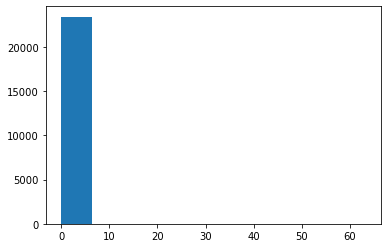

In [20]:
plt.hist(norms/std)
plt.show()

In [116]:
forces_A

Quantity(value=array([[  884.21677048,   236.5010269 ,   737.90093872],
       [ -246.01723362,  -726.68081789,  1106.61828328],
       [  694.47862604,  1334.4527537 , -1122.20194638],
       ...,
       [   -2.67210679,   -44.53739688,   -36.98542304],
       [ -212.33151881,  -878.08869214,  -796.96640084],
       [  140.48565587,  -145.0300547 ,  -247.5091858 ]]), unit=kilojoule/(nanometer*mole))

In [117]:
thermodynamic_state, sampler_state = retrieve_states(nc, thermodynamic_states, 1000, 18)
forces_A = retrieve_forces(thermodynamic_state, sampler_state, 0.5142857142857142 + 1e-3)

lambda_alchemical_sterics_new: 0.5142857142857142
lambda_alchemical_sterics_new: 0.5152857142857142


In [118]:
forces_B = retrieve_forces(thermodynamic_state, sampler_state, 0.5142857142857142 - 1e-3)

lambda_alchemical_sterics_new: 0.5132857142857142


In [119]:
norms = compute_norms(forces_A, forces_B)

In [120]:
for norm in norms:
    print(norm)

5.731994084416047e-07
4.1114883440051e-07
4.4278368474380697e-07
1.8764557505396037e-07
2.172690439551988e-07
1.8999922719667892e-07
6.910965061150327e-07
6.514861435054068e-07
8.091633656930772e-07
5.337637396069843e-07
4.017806157491842e-07
2.012366761901287e-07
1.4722007682244784e-07
2.0221216466254337e-07
5.669590317595322e-07
1.820595373750612e-07
1.3853198199136368e-07
1.6518277026506982e-07
1.3843701433986817e-07
1.300591584781811e-07
1.4808472915381643e-07
9.815696086702346e-08
1.51236590957326e-07
1.3376139209724758e-07
1.1915269902249872e-07
2.861297257133116e-07
2.627372200822169e-07
3.1144588165900184e-07
4.858598986612209e-07
1.0742599148778388e-06
1.0686741088553406e-06
5.480165925383511e-07
7.548219813700627e-07
2.207597892704824e-07
1.8510169062620278e-07
1.851419799858264e-07
6.083693394282704e-07
2.1532806342765375e-07
1.9137722439064514e-07
1.614511578222685e-07
2.3621316259402625e-07
9.237808258083667e-08
1.2301272444749671e-07
1.455511315135373e-07
2.21111150887281

5.823997378823114e-06
7.425351342409957e-08
4.4254913447943776e-08
4.141626501199429e-08
7.324683427934931e-07
3.80752306091805e-07
3.5192658382035395e-07
1.4177387950247293e-07
7.134255199245924e-08
7.323448816203304e-08
1.9987384715208712e-08
1.1093511699802247e-08
1.1573128604261636e-08
1.3589859008789063e-08
1.2862214169630509e-08
1.9234115025153972e-08
1.3160208851659557e-07
7.73081433837889e-08
7.021080904304521e-08
3.7909963569588743e-07
2.0092901684848878e-07
1.821568264316121e-07
4.376523554070956e-08
2.7403166561081643e-08
5.844562917449462e-08
1.3294438889834094e-07
8.526323079115908e-08
5.946381143381715e-08
1.5080163600181112e-07
6.837419206680466e-08
8.660011330236147e-08
1.9767761598540654e-07
9.649209623448394e-08
1.0732544152228837e-07
6.991206824936492e-07
3.8460768931230013e-07
3.2356589897401507e-07
6.259475357598091e-08
1.9481876391498207e-08
3.639301663034856e-08
1.5088432752296768e-06
8.970853174386158e-07
6.578853425994725e-07
8.908340397480637e-08
5.10304879934

2.741481926794031e-07
2.2457470177852874e-06
9.849603909021428e-07
1.214856176278661e-06
1.26982227643928e-06
6.917691140344647e-07
7.052228124104932e-07
4.229928470256479e-06
2.3986364171052867e-06
1.8390090964774768e-06
3.8418317306294753e-07
1.863001407885677e-07
1.8682590761045385e-07
2.886657315589013e-07
1.4420757167955312e-07
1.5175412792933285e-07
3.47876809391784e-07
1.612534678615113e-07
1.8005512527944825e-07
3.9218676833416805e-07
2.1291780288070573e-07
1.9962335907700055e-07
1.3757413124317195e-07
7.592583678303915e-08
6.796226043146164e-08
1.3147229799161906e-06
7.458890476941382e-07
6.458305188772847e-07
2.9164440008437333e-07
1.4973580098760966e-07
1.3191163712119986e-07
1.6476224645991678e-07
8.792572057563893e-08
9.569588367402026e-08
4.0509688514640046e-07
2.0647850775401488e-07
2.022568548687191e-07
1.5073183852454506e-07
8.667556524372847e-08
8.30011746438235e-08
4.9260417251065115e-08
2.6417165884215137e-08
1.5449910247352507e-08
2.9953458933631195e-07
1.682829875

5.596703865926061e-07
9.671804578986287e-08
5.844293170489946e-08
4.6990239472129606e-08
1.1907188125639983e-07
6.332515950990224e-08
7.27866433878447e-08
3.879380199101011e-07
1.8537623313625812e-07
1.966697502845801e-07
4.700173008099216e-08
2.364073802230938e-08
2.0343965511314237e-08
2.164168400499381e-07
9.658277490698867e-08
1.1710236210000286e-07
3.2536266409429253e-07
1.538950836820915e-07
1.7494547093346132e-07
2.9445852805147145e-07
1.4888700997732147e-07
1.5542843455588336e-07
3.9361636593578e-08
1.6545631001374694e-08
1.0414280733032968e-08
4.2317706064727e-07
2.492924774441957e-07
1.95652537007926e-07
1.6058301055643411e-07
9.07106715916883e-08
7.166213668012446e-08
6.720190430079697e-08
2.8370057781134247e-08
2.9699146965243933e-08
3.4778561968137634e-07
1.6393908376205144e-07
1.7628857402922175e-07
9.637357257068694e-07
4.253374682010233e-07
4.883381155734103e-07
4.512000902244233e-07
2.1360292491617553e-07
1.9595179040485532e-07
1.633826700440132e-07
8.665096856876599e-

2.409552101056925e-07
1.3251955778877877e-07
1.1488609352660652e-07
3.325358035817776e-07
1.6363037231085047e-07
1.7298253765444844e-07
2.9074352845436563e-07
1.5170753291498312e-07
1.4201109015836628e-07
1.1310693987909607e-07
5.5822542238324256e-08
5.2894546754169e-08
3.0066917761357837e-07
1.5028265506534511e-07
1.4353373952034033e-07
1.2300491185128403e-06
5.485376825303332e-07
6.07063893702602e-07
2.6001314180044775e-07
1.309192685158709e-07
1.2660481153828326e-07
6.037184020794323e-07
2.9412942148247644e-07
2.8975401394441506e-07
6.670186610364775e-07
3.4373113397722424e-07
3.441671081657544e-07
1.3558472813338593e-07
6.697059297284066e-08
7.082398861436681e-08
8.582837048685413e-08
5.856562041045204e-08
4.1890161734242485e-08
3.0318594956476475e-07
1.5243880618234427e-07
1.5193381791325686e-07
6.094043505660669e-07
2.6799404299228e-07
2.8997948822508874e-07
7.683100026864839e-07
3.8398257758794283e-07
4.1243657808318603e-07
9.02772508586034e-08
3.0743981017713296e-08
6.212915101

3.204502693656145e-07
1.312684111245128e-06
6.514021439265914e-07
5.781815221741849e-07
3.328705905037182e-07
1.9179526247514004e-07
1.578100481516363e-07
5.47512058044713e-08
4.5547309632337776e-08
4.9305976694910294e-08
7.041670837323094e-07
3.167606846381221e-07
3.3876991882607076e-07
9.265530048048505e-08
5.1613354891949596e-08
4.8156421786345223e-08
6.750941949103597e-07
3.2353638371924305e-07
3.204278292401007e-07
2.190245808196393e-07
1.0580469165553807e-07
1.148285028564021e-07
2.7808601795365807e-07
1.446171320568998e-07
1.4524055946229792e-07
2.4964975520078585e-07
1.1893771948121891e-07
1.186721142880791e-07
3.4375296235501405e-07
1.6378783753226092e-07
1.7122969390479366e-07
2.7182394866298014e-07
1.4437401573223218e-07
1.395830321889273e-07
2.4803050441956253e-07
1.3427877459251393e-07
1.2190255917029747e-07
5.792949391942499e-07
2.7405860474629767e-07
2.99260812317414e-07
1.6257350155297982e-07
9.007837601381388e-08
7.606150564770893e-08
4.7002431521915136e-07
2.203869388

1.842728178882232e-07
1.8649103695765164e-07
2.394102453957051e-07
1.3292814013488602e-07
1.0713035817018713e-07
2.3422559617950556e-07
1.2324672503317878e-07
1.1559933240788909e-07
1.1536423564285974e-07
5.592351598919157e-08
5.4272938541967466e-08
1.32712442044852e-07
7.362618960833227e-08
6.710183325220387e-08
1.9596788967165488e-08
1.250334406156758e-08
2.209073903064442e-08
1.5843627668224477e-08
2.4036566087967987e-08
9.617161410814408e-09
2.498442712681244e-07
1.2175255074921584e-07
1.2138667004009628e-07
1.6365746642279974e-07
7.592237410395065e-08
8.244449848852065e-08
4.0290228635643074e-07
2.1054034528351872e-07
2.0121179158074045e-07
3.634650380939316e-07
1.9908051290660995e-07
2.0789348190604557e-07
1.761343777484267e-07
6.508958207373699e-08
6.974937976516611e-08
6.38543176880957e-07
3.392269948134979e-07
3.4992733110200444e-07
1.3406270554792313e-07
7.459882651441523e-08
6.023266858916522e-08
6.735629944094853e-07
3.2392586651220464e-07
3.858347099035625e-07
1.6433388627

In [100]:
n_states = 36
lambda_schedule = np.linspace(0.,1.,n_states)

In [101]:
lambda_schedule

array([0.        , 0.02857143, 0.05714286, 0.08571429, 0.11428571,
       0.14285714, 0.17142857, 0.2       , 0.22857143, 0.25714286,
       0.28571429, 0.31428571, 0.34285714, 0.37142857, 0.4       ,
       0.42857143, 0.45714286, 0.48571429, 0.51428571, 0.54285714,
       0.57142857, 0.6       , 0.62857143, 0.65714286, 0.68571429,
       0.71428571, 0.74285714, 0.77142857, 0.8       , 0.82857143,
       0.85714286, 0.88571429, 0.91428571, 0.94285714, 0.97142857,
       1.        ])

In [102]:
lambda_schedule[18]

0.5142857142857142